<a href="https://colab.research.google.com/github/anushribhargava/Fashion_Recommendation_System/blob/main/fashion_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from numpy.linalg import norm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
import zipfile

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

# Path to your dataset archive in Google Drive
zip_path = "/content/drive/MyDrive/fashion_pred/archive.zip" # replace with actual path
extract_dir = "/content/drive/MyDrive/fashion_pred/images_dataset"

# Unzip archive
# if not os.path.exists(extract_dir):
#     os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print(f"Extracted archive to: {extract_dir}")

# Find the image folder automatically
def find_image_folder(root_dir):
    for root, dirs, files in os.walk(root_dir):
        if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in files):
            return root
    return None

image_folder = find_image_folder(extract_dir)
print(" Using image folder:", image_folder)

#  Load ResNet50 (pretrained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

feature_model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

#  Function to load + preprocess image
def preprocess_img(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Collect filenames
filenames = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

#Batch feature extraction
batch_size = 32
featurelist = []

for i in tqdm(range(0, len(filenames), batch_size), desc="Extracting features"):
    batch_files = filenames[i:i+batch_size]
    batch_imgs = np.vstack([preprocess_img(f) for f in batch_files])

    batch_features = feature_model.predict(batch_imgs, verbose=0)
    batch_normed = batch_features / np.linalg.norm(batch_features, axis=1, keepdims=True)
    featurelist.extend(batch_normed)

#Save embeddings + filenames
with open("embeddings.pkl", "wb") as f:
    pickle.dump(featurelist, f)

with open("filenames.pkl", "wb") as f:
    pickle.dump(filenames, f)

print("Feature extraction complete")


Num GPUs Available:  1
TensorFlow version: 2.19.0
 Using image folder: /content/drive/MyDrive/fashion_pred/images_dataset/images


Extracting features: 100%|██████████| 1389/1389 [10:29<00:00,  2.21it/s]


Feature extraction complete


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loaded 44441 embeddings

Query image: /content/drive/MyDrive/fashion_pred/images_dataset/images/29788.jpg


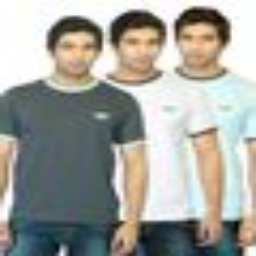

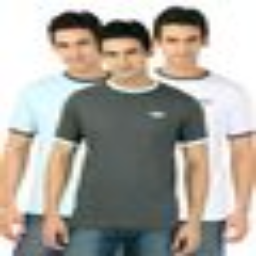

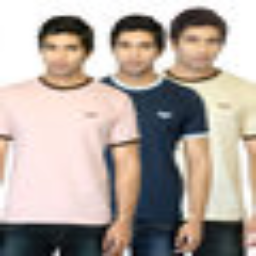

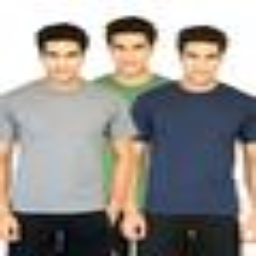

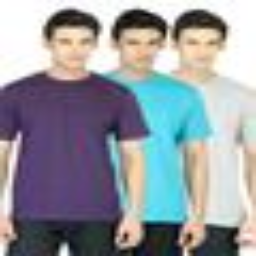

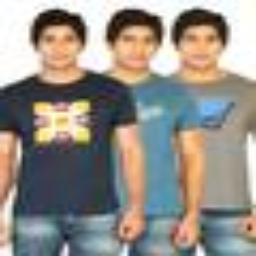


Query image: /content/drive/MyDrive/fashion_pred/images_dataset/images/30596.jpg


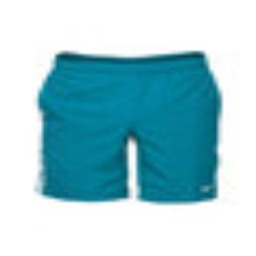

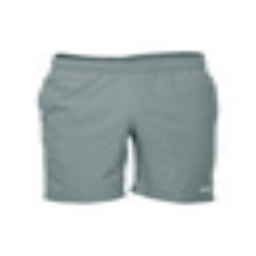

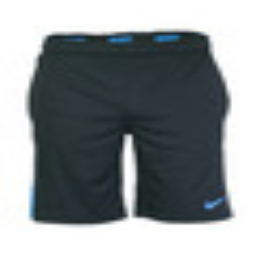

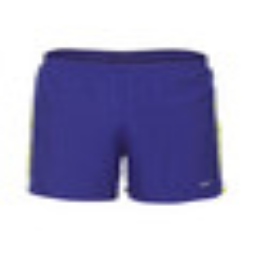

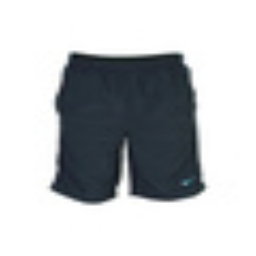

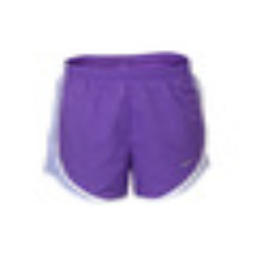


Query image: /content/drive/MyDrive/fashion_pred/images_dataset/images/26682.jpg


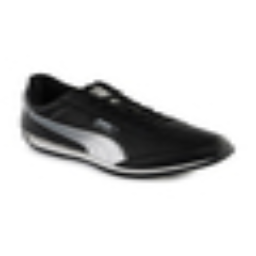

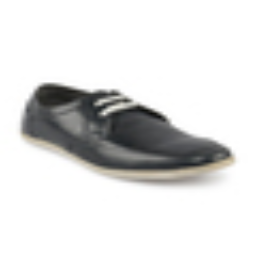

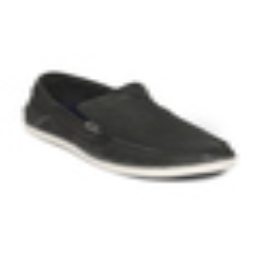

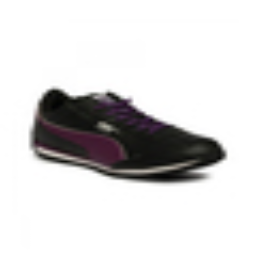

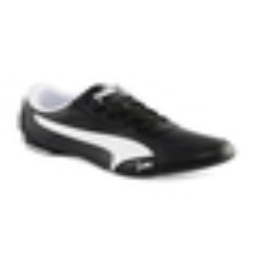

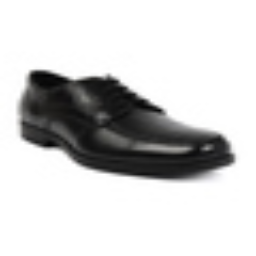


Query image: /content/drive/MyDrive/fashion_pred/images_dataset/images/28362.jpg


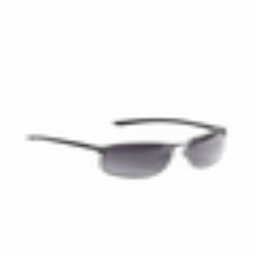

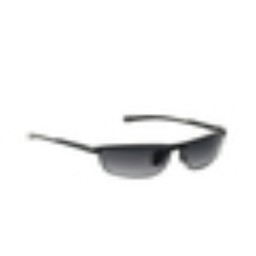

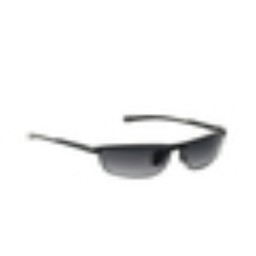

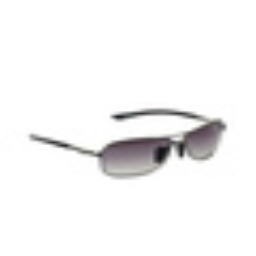

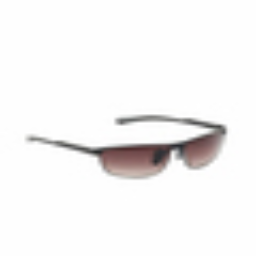

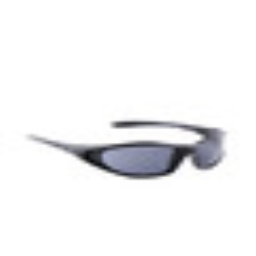


Query image: /content/drive/MyDrive/fashion_pred/images_dataset/images/50816.jpg


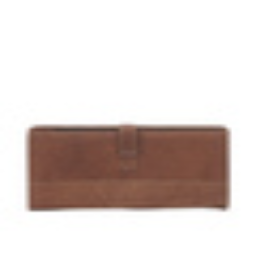

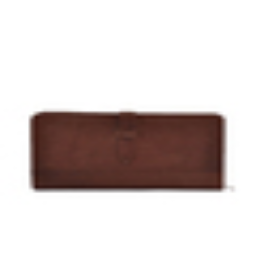

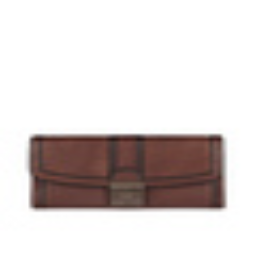

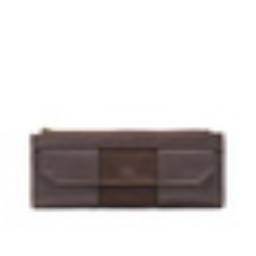

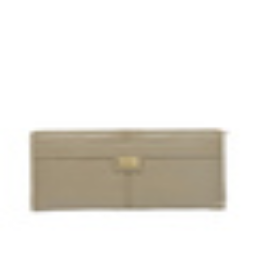

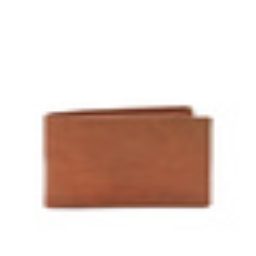

In [ ]:
import pickle
import numpy as np
import random
import cv2
from google.colab.patches import cv2_imshow
from sklearn.neighbors import NearestNeighbors

# Load embeddings and filenames
feature_list = np.array(pickle.load(open("embeddings.pkl", "rb")))
filenames = pickle.load(open("filenames.pkl", "rb"))

print(f"Loaded {len(feature_list)} embeddings")

# Fit NearestNeighbors model
neighbors = NearestNeighbors(n_neighbors=6, algorithm="brute", metric="euclidean")
neighbors.fit(feature_list)

# Pick 5 random query images
query_indices = random.sample(range(len(filenames)), 5)

for q_idx in query_indices:
    query_img_path = filenames[q_idx]
    query_embedding = feature_list[q_idx]

    print(f"\nQuery image: {query_img_path}")

    distances, indices = neighbors.kneighbors([query_embedding])

    # Show query image
    query_img = cv2.imread(query_img_path)
    query_img = cv2.resize(query_img, (256, 256))
    cv2_imshow(query_img)

    # Show recommendations
    for file_idx in indices[0][1:6]:
        rec_img = cv2.imread(filenames[file_idx])
        rec_img = cv2.resize(rec_img, (256, 256))
        cv2_imshow(rec_img)
